###  Modèle type LeNet avec détourage

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../files_detour.csv',index_col=0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31603 entries, 0 to 31602
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      31603 non-null  int64 
 1   file_path  31603 non-null  object
 2   filename   31603 non-null  object
 3   class      31603 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [4]:
data = data.drop(data[(data['class']=='blast' ) | (data['class']=='smudge')].index)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25402 entries, 0 to 31563
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      25402 non-null  int64 
 1   file_path  25402 non-null  object
 2   filename   25402 non-null  object
 3   class      25402 non-null  object
dtypes: int64(1), object(3)
memory usage: 992.3+ KB


In [8]:
data['class'].value_counts()

neutrophil      5400
lymphocyte      4613
ig              3815
eosinophil      3222
monocyte        2713
platelet        2410
erythroblast    1966
basophil        1263
Name: class, dtype: int64

In [9]:
src_img = '../images_detour/'

In [10]:
data['file_path'] = data['filename'].apply(lambda file :  src_img + file)

In [11]:
lst_classes = {'basophil':0,'eosinophil':1,
               'erythroblast':2,'ig':3,'lymphocyte':4,'monocyte':5,'neutrophil':6,'platelet':7}

In [12]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [13]:
data.head()

,index,file_path,filename,class,label
0,0,../images_detour/BA_100102.jpg,BA_100102.jpg,basophil,0
1,1,../images_detour/BA_101381.jpg,BA_101381.jpg,basophil,0
2,2,../images_detour/BA_101611.jpg,BA_101611.jpg,basophil,0
3,3,../images_detour/BA_102039.jpg,BA_102039.jpg,basophil,0
4,4,../images_detour/BA_102750.jpg,BA_102750.jpg,basophil,0


In [14]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

##### Mise au format Tensor

In [15]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224,224]) 
    img = tf.cast(img, tf.float32)/255
    return img

In [16]:
AUTO = tf.data.experimental.AUTOTUNE

In [17]:
dataset_train = tf.data.Dataset.from_tensor_slices((data_train['file_path'],data_train['label']))
dataset_test = tf.data.Dataset.from_tensor_slices((data_test['file_path'],data_test['label']))

dataset_train = (dataset_train.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(1000).batch(32))
dataset_test = (dataset_test.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(500).batch(32))

#### Modèle type LeNet
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam

In [18]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [19]:
# Création d'un modèle CNN type LeNet
def model_CNN():
    model =  Sequential()
    model.add(Conv2D(filters = 30  , kernel_size=(5,5), padding='valid', input_shape=(224,224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 16  , kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(units=1024,activation='relu'))
    model.add(Dense(units=512,activation='relu'))
    model.add(Dense(units=256,activation='relu'))
    model.add(Dense(units=8,activation='softmax')) #8Classes
    #Compilation
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
model = model_CNN()

In [21]:
#Entrainement
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[callback])

Epoch 1/16
643/643 [==============================] - 1003s 2s/step - loss: 0.7836 - accuracy: 0.7168 - val_loss: 0.5407 - val_accuracy: 0.8177
Epoch 2/16
643/643 [==============================] - 964s 1s/step - loss: 0.4166 - accuracy: 0.8572 - val_loss: 0.4139 - val_accuracy: 0.8575
Epoch 3/16
643/643 [==============================] - 997s 2s/step - loss: 0.3130 - accuracy: 0.8942 - val_loss: 0.3706 - val_accuracy: 0.8767
Epoch 4/16
643/643 [==============================] - 1030s 2s/step - loss: 0.2434 - accuracy: 0.9178 - val_loss: 0.3586 - val_accuracy: 0.8802
Epoch 5/16
643/643 [==============================] - 968s 2s/step - loss: 0.2055 - accuracy: 0.9315 - val_loss: 0.3326 - val_accuracy: 0.8981
Epoch 6/16
643/643 [==============================] - 962s 1s/step - loss: 0.1639 - accuracy: 0.9452 - val_loss: 0.3523 - val_accuracy: 0.8885
Epoch 7/16
643/643 [==============================] - 975s 2s/step - loss: 0.1221 - accuracy: 0.9593 - val_loss: 0.3690 - val_accuracy: 0.89

In [22]:
model.save_weights("lenet_8_weights_2_bases")

#### Prédiction sur les données d'évaluation

In [23]:
dataset_eval = tf.data.Dataset.from_tensor_slices((data_eval['file_path'],data_eval['label']))
dataset_eval = (dataset_eval.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).batch(32))

In [24]:
model.evaluate(dataset_eval)

80/80 [==============================] - 33s 411ms/step - loss: 0.3436 - accuracy: 0.8930


[0.34363165497779846, 0.8929555416107178]

 * Score similaire avec détourage que sans détourage

In [25]:
#Classes prédites
predict = model.predict(dataset_eval)

In [26]:
lst_classes = ['basophil','eosinophil',
               'erythroblast','ig','lymphocyte','monocyte','neutrophil','platelet']
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval['label'] ]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.89      0.85      0.87       110
  eosinophil       0.96      0.96      0.96       305
erythroblast       0.83      0.90      0.86       206
          ig       0.80      0.75      0.78       380
  lymphocyte       0.91      0.94      0.92       474
    monocyte       0.87      0.80      0.83       277
  neutrophil       0.90      0.92      0.91       559
    platelet       0.98      1.00      0.99       230

    accuracy                           0.89      2541
   macro avg       0.89      0.89      0.89      2541
weighted avg       0.89      0.89      0.89      2541



> Baisse du score sur les basophil et erythroblast, amélioration sur les autres classes

In [27]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Réalité,,,,,,,,
basophil,93,6,2,9,0,0,0,0
eosinophil,0,292,1,2,1,2,7,0
erythroblast,0,0,185,8,10,0,1,2
ig,8,3,14,285,12,21,37,0
lymphocyte,1,0,11,5,446,7,3,1
monocyte,1,0,1,35,11,221,7,1
neutrophil,2,4,10,11,12,2,517,1
platelet,0,0,0,0,0,0,0,230


> Confusion importante neutrophil/IG ainsi que monocyte/IG


### GRAD CAM

In [28]:
import gradcam_dataset

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 30)      2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      4336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4

In [31]:
img_size = (255, 255)
last_conv_layer_name = "conv2d_1"

##### BASOPHIL

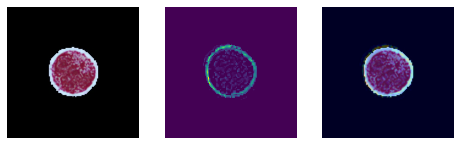

In [32]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### EOSINOPHIL

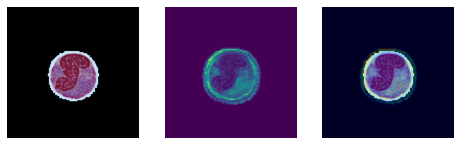

In [33]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### ERYTHROBLAST

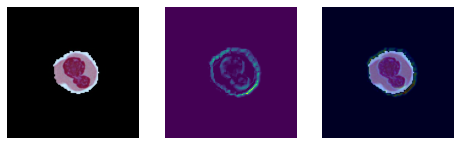

In [34]:
path = data[data['filename']=='ERB_763618.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### IG

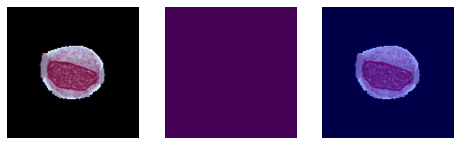

In [35]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### LYMPHOCYTE

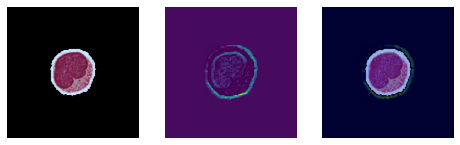

In [36]:
path = data[data['filename']=='LY_875873.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### MONOCYTE

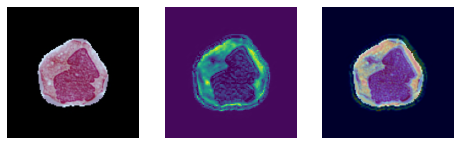

In [37]:
path = data[data['filename']=='MO_60562.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### NEUTROPHIL

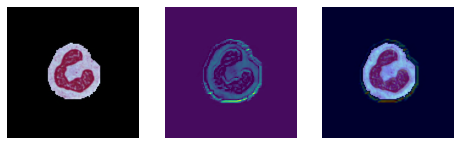

In [38]:
path = data[data['filename']=='BNE_53394.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### PLATELET

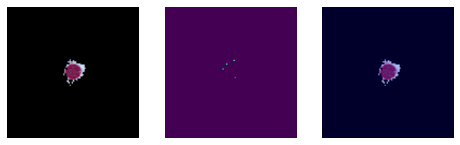

In [39]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)